In [8]:
using Gmsh: gmsh
using GridapGmsh
using Gridap
using Gridap.Geometry
using Gridap.TensorValues


println("\n" * "="^80)
println("🧪 TEST RAPIDE - Simulation avec effet de l'eau")
println("="^80)



🧪 TEST RAPIDE - Simulation avec effet de l'eau


In [9]:
# PARAMÈTRES SIMPLIFIÉS
# ============================================================================

I2 = one(TensorValue{2,2,Float64})
I4_sym = one(SymFourthOrderTensorValue{2,Float64})
I4_vol = (1.0/2)*I4_sym
I4_dev = I4_sym - I4_vol

const ls = 0.01 
const η = 1e-15

1.0e-15

Renseigner

Parametres materiaux pour la simulation

In [10]:
# Matériau sec
const E_dry = 0.83
const ν_dry = 0.22
const Gc_dry =0.005 # 0.000308*3

# Matériau saturé
const E_sat = 0.21
const ν_sat = 0.25
const Gc_sat =0.005 # 0.0000308*3

# Humidité globale pour ce test
const θ_global =0.99# 100% d'humidité


0.99

In [11]:

println("\n📋 Configuration:")
println("   θ (humidité) = $θ_global")
println("   E(θ) = $(E_dry + θ_global*(E_sat - E_dry)) GPa")
println("   Gc(θ) = $(Gc_dry*exp(-2.5*θ_global)) kN/mm")


📋 Configuration:
   θ (humidité) = 0.99
   E(θ) = 0.21619999999999995 GPa
   Gc(θ) = 0.0004208149512865518 kN/mm


In [12]:
# ============================================================================
# FONCTIONS DE BASE
# ============================================================================

function E_moisture(θ)
    return E_dry + θ * (E_sat - E_dry)
end

function Gc_moisture(θ)
    α = 2.5
    return Gc_dry * exp(-α * θ)
end

function C_tensor(θ)
    E = E_moisture(θ)
    ν = ν_dry + θ * (ν_sat - ν_dry)
    G = E / (2 * (1 + ν))
    
    C1111 = (E * (1 - ν^2)) / ((1 + ν) * (1 - ν - 2*ν^2))
    C1122 = (ν * E) / (1 - ν - 2*ν^2)
    C2222 = (E * (1 - ν)) / (1 - ν - 2*ν^2)
    C1212 = G
    
    return SymFourthOrderTensorValue(C1111, 0.0, C1122, 
                                     0.0, C1212, 0.0, 
                                     C1122, 0.0, C2222)
end

C_tensor (generic function with 1 method)

In [13]:
const C_mat = C_tensor(θ_global)

σ_elas(ε) = C_mat ⊙ ε

function σ_mod(ε, ε_in, s_in)
    if tr(ε_in) >= 0
        σ = (s_in^2 + η) * σ_elas(ε)
    else
        σ = (s_in^2 + η) * I4_dev ⊙ σ_elas(ε) + I4_vol ⊙ σ_elas(ε)
    end
    return σ
end

σ_mod (generic function with 1 method)

In [14]:
function ψPos(ε_in)
    if tr(ε_in) >= 0
        ψPlus = 0.5 * (ε_in ⊙ σ_elas(ε_in))
    else
        ψPlus = 0.5 * ((I4_dev ⊙ σ_elas(ε_in)) ⊙ (I4_dev ⊙ ε_in))
    end
    return ψPlus
end


ψPos (generic function with 1 method)

In [15]:

function new_EnergyState(ψPlusPrev_in, ψhPos_in)
    if ψhPos_in >= ψPlusPrev_in
        return true, ψhPos_in
    else
        return true, ψPlusPrev_in
    end
end

new_EnergyState (generic function with 1 method)

In [16]:

function project(q,model,dΩ,order)
  reffe = ReferenceFE(lagrangian,Float64,order)
  V = FESpace(model,reffe,conformity=:L2)
  a(u,v) = ∫( u*v )*dΩ
  l(v) = ∫( v*q )*dΩ
  op = AffineFEOperator(a,l,V,V)
  qh = solve(op)
  qh
end

project (generic function with 1 method)

In [18]:
# ============================================================================
# CHARGEMENT DU MAILLAGE
# ============================================================================

model = GmshDiscreteModel("BeamWithNotchSymThreePtBending_L190_H60.msh")
writevtk(model ,"BeamWithNotchSymThreePtBending_L190_H60")



Info    : Reading 'BeamWithNotchSymThreePtBending_L190_H60.msh'...
Info    : 19 entities
Info    : 4662 nodes
Info    : 9068 elements
Info    : Done reading 'BeamWithNotchSymThreePtBending_L190_H60.msh'


3-element Vector{Vector{String}}:
 ["BeamWithNotchSymThreePtBending_L190_H60_0.vtu"]
 ["BeamWithNotchSymThreePtBending_L190_H60_1.vtu"]
 ["BeamWithNotchSymThreePtBending_L190_H60_2.vtu"]

In [19]:

order = 1
degree = 2 * order

Ω = Triangulation(model)
dΩ = Measure(Ω, degree)

labels = get_face_labeling(model)
LoadTagId = get_tag_from_name(labels, "LoadLine")
Γ_Load = BoundaryTriangulation(model, tags=LoadTagId)
dΓ_Load = Measure(Γ_Load, degree)
n_Γ_Load = get_normal_vector(Γ_Load)


GenericCellField():
 num_cells: 22
 DomainStyle: ReferenceDomain()
 Triangulation: BoundaryTriangulation()
 Triangulation id: 4488318312101219262

In [20]:

# ============================================================================
# ESPACES EF
# ============================================================================
println("🔧 Création des espaces éléments finis...")

reffe_PF = ReferenceFE(lagrangian, Float64, order)
V0_PF = TestFESpace(model, reffe_PF; conformity=:H1)
U_PF = TrialFESpace(V0_PF)
sh = zero(V0_PF)

reffe_Disp = ReferenceFE(lagrangian, VectorValue{2,Float64}, order)
V0_Disp = TestFESpace(model, reffe_Disp;
    conformity=:H1,
    dirichlet_tags=["LeftSupport", "RightSupport", "LoadLine"],
    dirichlet_masks=[(false, true), (true, true), (false, true)])
uh = zero(V0_Disp)

println("   ✅ Espaces créés")
println("   DOF champ de phase: ", num_free_dofs(U_PF))
println("   DOF déplacement: ", num_free_dofs(V0_Disp))

🔧 Création des espaces éléments finis...
   ✅ Espaces créés
   DOF champ de phase: 4662
   DOF déplacement: 9300


In [21]:
# ============================================================================
# RÉSOLUTION
# ============================================================================

function stepPhaseField(uh_in, ψPlusPrev_in)
    Gc = Gc_moisture(θ_global)
    a_PF(s, ϕ) = ∫(Gc * ls * ∇(ϕ) ⋅ ∇(s) + 
                   2 * ψPlusPrev_in * s * ϕ + 
                   (Gc / ls) * s * ϕ) * dΩ
    b_PF(ϕ) = ∫((Gc / ls) * ϕ) * dΩ
    return solve(AffineFEOperator(a_PF, b_PF, U_PF, V0_PF))
end

# ✅ CORRECTION PRINCIPALE: b_Disp doit être une fonction
function stepDisp(uh_in, sh_in, vApp)
    uApp1(x) = VectorValue(0.0, 0.0)
    uApp2(x) = VectorValue(0.0, 0.0)
    uApp3(x) = VectorValue(0.0, -vApp)
    U_Disp = TrialFESpace(V0_Disp, [uApp1, uApp2, uApp3])
    
    a_Disp(u, v) = ∫((ε(v) ⊙ (σ_mod ∘ (ε(u), ε(uh_in), sh_in)))) * dΩ
    b_Disp(v) = 0.0  # ✅ FONCTION qui retourne 0, pas juste 0.0
    
    op_Disp = AffineFEOperator(a_Disp, b_Disp, U_Disp, V0_Disp)
    uh_out = solve(op_Disp)
    return uh_out
end


stepDisp (generic function with 1 method)

In [22]:
# ============================================================================
# BOUCLE DE RÉSOLUTION AVEC SAUVEGARDE D'HISTORIQUE
# Remplacer la cellule 27 par ce code
# ============================================================================
vApp = 0
delv = 1e-3
const vAppMax = 10
innerMax = 10
count = 0

# Vecteurs de résultats
Load = Float64[]
Displacement = Float64[]

# ✅ NOUVEAU: Sauvegarder l'historique
sh_history = []  # Liste des champs de phase
save_interval = 5  # Sauvegarder tous les N pas

push!(Load, 0.0)
push!(Displacement, 0.0)

sPrev = CellState(1.0, dΩ)
sh = project(sPrev, model, dΩ, order)
push!(sh_history, deepcopy(sh))  # État initial

ψPlusPrev = CellState(0.0, dΩ)

# Suivi de progression
start_time = time()

println("\n" * "="^80)
println("🚀 DÉBUT DE LA SIMULATION")
println("="^80)
println("   Déplacement max: $(vAppMax*1000) µm")
println("   Sauvegarde historique tous les $save_interval pas")
println()

while vApp < vAppMax 
    count += 1
    
    # Ajustement adaptatif du pas
    if vApp >= 3e-2
        delv = 5e-2
    elseif vApp >= 4e-2
        delv = 1e-3
    end
    vApp += delv
    
    # Affichage de progression
    progress = 100 * vApp / vAppMax
    elapsed = time() - start_time
    eta = elapsed / progress * (100 - progress)
    
    print("\r🔄 Pas $count | δ = $(round(vApp*1000, digits=2)) µm | ")
    print("Progression: $(round(progress, digits=1))% | ")
    print("Temps: $(round(elapsed, digits=1))s | ")
    print("ETA: $(round(eta, digits=1))s     ")
    flush(stdout)
    
    # Boucle alternée phase field / déplacement
    for inner = 1:innerMax
        ψhPlusPrev = project(ψPlusPrev, model, dΩ, order)
        Gc = Gc_moisture(θ_global)
        
        # Calcul de l'erreur de convergence
        RelErr = abs(sum(∫(Gc*ls*∇(sh)⋅∇(sh) + 2*ψhPlusPrev*sh*sh + (Gc/ls)*sh*sh)*dΩ - 
                        ∫((Gc/ls)*sh)*dΩ)) / 
                 abs(sum(∫((Gc/ls)*sh)*dΩ))
        
        # Résolution alternée
        sh = stepPhaseField(uh, ψhPlusPrev) 
        uh = stepDisp(uh, sh, vApp)
        
        # Mise à jour état énergétique
        ψhPos_in = ψPos ∘ (ε(uh))    
        update_state!(new_EnergyState, ψPlusPrev, ψhPos_in)
        
        # Test de convergence
        if RelErr < 1e-8
            break 
        end      
    end
    
    # Calcul de la force de réaction
    Node_Force = sum(∫(n_Γ_Load ⋅ (σ_mod ∘ (ε(uh), ε(uh), sh)))*dΓ_Load)
    
    push!(Load, -Node_Force[2])
    push!(Displacement, vApp)
    
    # ✅ Sauvegarder l'historique du champ de phase
    if count % save_interval == 0 || vApp >= 0.04 || abs(vApp - vAppMax) < delv
        push!(sh_history, deepcopy(sh))
    end
    
    # Sauvegarde VTK sélective
    save_vtk = (vApp <= 4e-2 && mod(count, 10) == 0) || vApp > 4e-2
    
    if save_vtk
        writevtk(Ω, "results_Step$(lpad(count, 4, '0'))", cellfields=[
            "displacement" => uh,
            "phase_field" => sh,
            "disp_magnitude" => uh,
            "epsilon" => ε(uh),
            "sigma" => σ_elas ∘ (ε(uh))
        ])
    end
end 

# Affichage final
println("\n" * "="^80)
println("✅ SIMULATION TERMINÉE!")
println("="^80)
println("   Temps total: $(round(time() - start_time, digits=2)) secondes")
println("   Nombre de pas: $count")
println("   Points sauvegardés: $(length(sh_history))")
println("="^80)


🚀 DÉBUT DE LA SIMULATION
   Déplacement max: 10000 µm
   Sauvegarde historique tous les 5 pas

🔄 Pas 230 | δ = 10030.0 µm | Progression: 100.3% | Temps: 725.5s | ETA: -2.2s     s: 81.3s | ETA: 4434.4s     Progression: 4.8% | Temps: 86.2s | ETA: 1710.5s     Progression: 5.3% | Temps: 86.6s | ETA: 1547.6s     Progression: 5.8% | Temps: 87.6s | ETA: 1422.4s     Progression: 6.8% | Temps: 88.9s | ETA: 1218.3s     Progression: 7.8% | Temps: 90.8s | ETA: 1073.2s     Temps: 91.2s | ETA: 1007.6s     ETA: 748.5s     Progression: 11.8% | Temps: 96.3s | ETA: 719.8s     Temps: 98.9s | ETA: 617.9s     Progression: 15.3% | Temps: 101.4s | ETA: 561.3s     Progression: 20.3% | Temps: 111.4s | ETA: 437.5s     Temps: 113.8s | ETA: 433.4s     Progression: 21.3% | Temps: 114.2s | ETA: 422.0s     Temps: 119.8s | ETA: 405.5s     Temps: 124.9s | ETA: 399.8s     Temps: 132.8s | ETA: 392.2s     Temps: 165.2s | ETA: 418.5s     Temps: 182.1s | ETA: 439.3s     Temps: 228.0s | ETA: 408.8s     Progression: 36.3% |

In [23]:
# ============================================================================
# RÉSULTATS
# ============================================================================
println("\n📊 RÉSULTATS DU TEST:")
println("="^80)
println("   Force maximale: $(round(maximum(Load), digits=4)) kN")
println("   Déplacement final: $(round(Displacement[end]*1000, digits=2)) μm")

# Statistiques du champ de phase
sh_values = get_free_dof_values(sh)
println("   Champ de phase s:")
println("      • min = $(round(minimum(sh_values), digits=4))")
println("      • max = $(round(maximum(sh_values), digits=4))")
println("      • moy = $(round(sum(sh_values)/length(sh_values), digits=4))")

# Sauvegarder
writevtk(Ω, "test_laterite_water", cellfields=
    ["u" => uh, "s" => sh, "epsilon" => ε(uh), "sigma" => σ_elas ∘ (ε(uh))])

println("\n💾 Fichier VTK sauvegardé: test_laterite_water.vtu")
println("   Visualisez avec ParaView!")

println("\n" * "="^80)
println("✅ TEST RÉUSSI!")
println("="^80)
println("\n💡 Prochaines étapes:")
println("   1. Vérifier le fichier VTK dans ParaView")
println("   2. Ajuster θ_global et relancer")
println("   3. Passer au code complet avec gradient d'humidité")
println("\n")


📊 RÉSULTATS DU TEST:


   Force maximale: 0.1221 kN
   Déplacement final: 10030.0 μm
   Champ de phase s:
      • min = -0.0
      • max = 1.2013
      • moy = 0.9468

💾 Fichier VTK sauvegardé: test_laterite_water.vtu
   Visualisez avec ParaView!

✅ TEST RÉUSSI!

💡 Prochaines étapes:
   1. Vérifier le fichier VTK dans ParaView
   2. Ajuster θ_global et relancer
   3. Passer au code complet avec gradient d'humidité





🎨 GÉNÉRATION DES POST-TRAITEMENTS

1️⃣  Courbe Force-Déplacement...


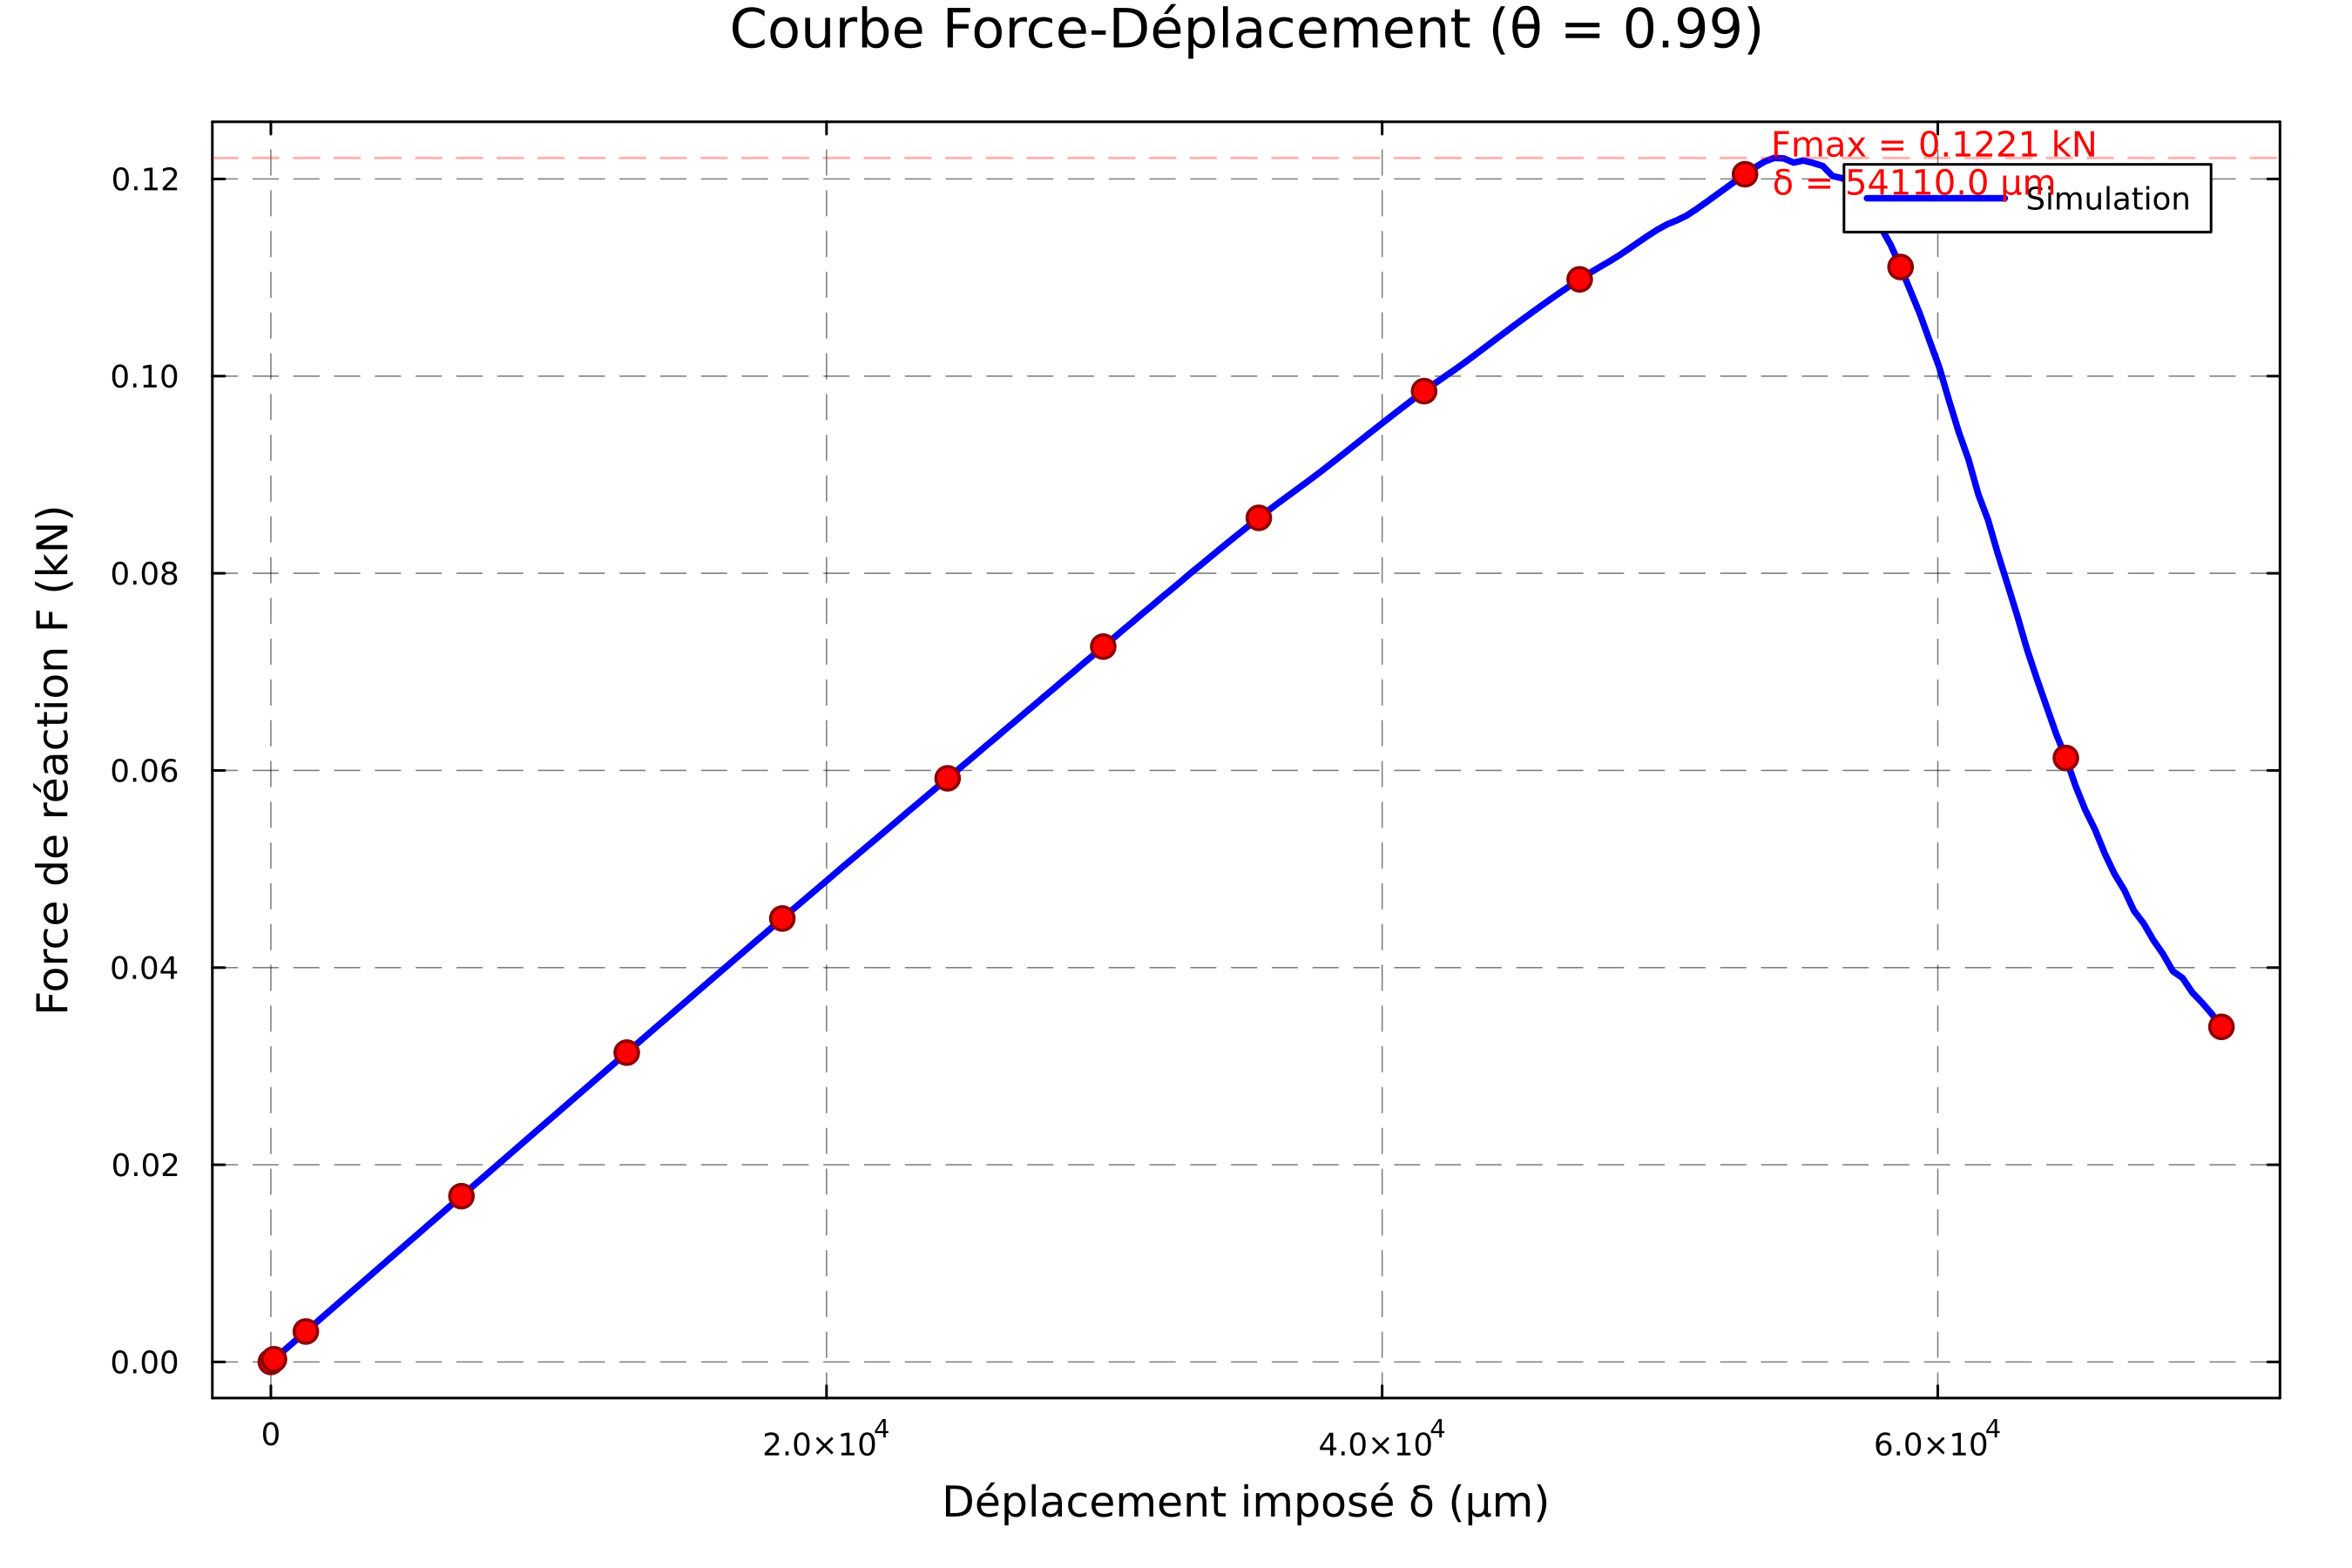


📊 Figure sauvegardée: force_displacement_theta_0.99.png

2️⃣  Analyse Énergétique...


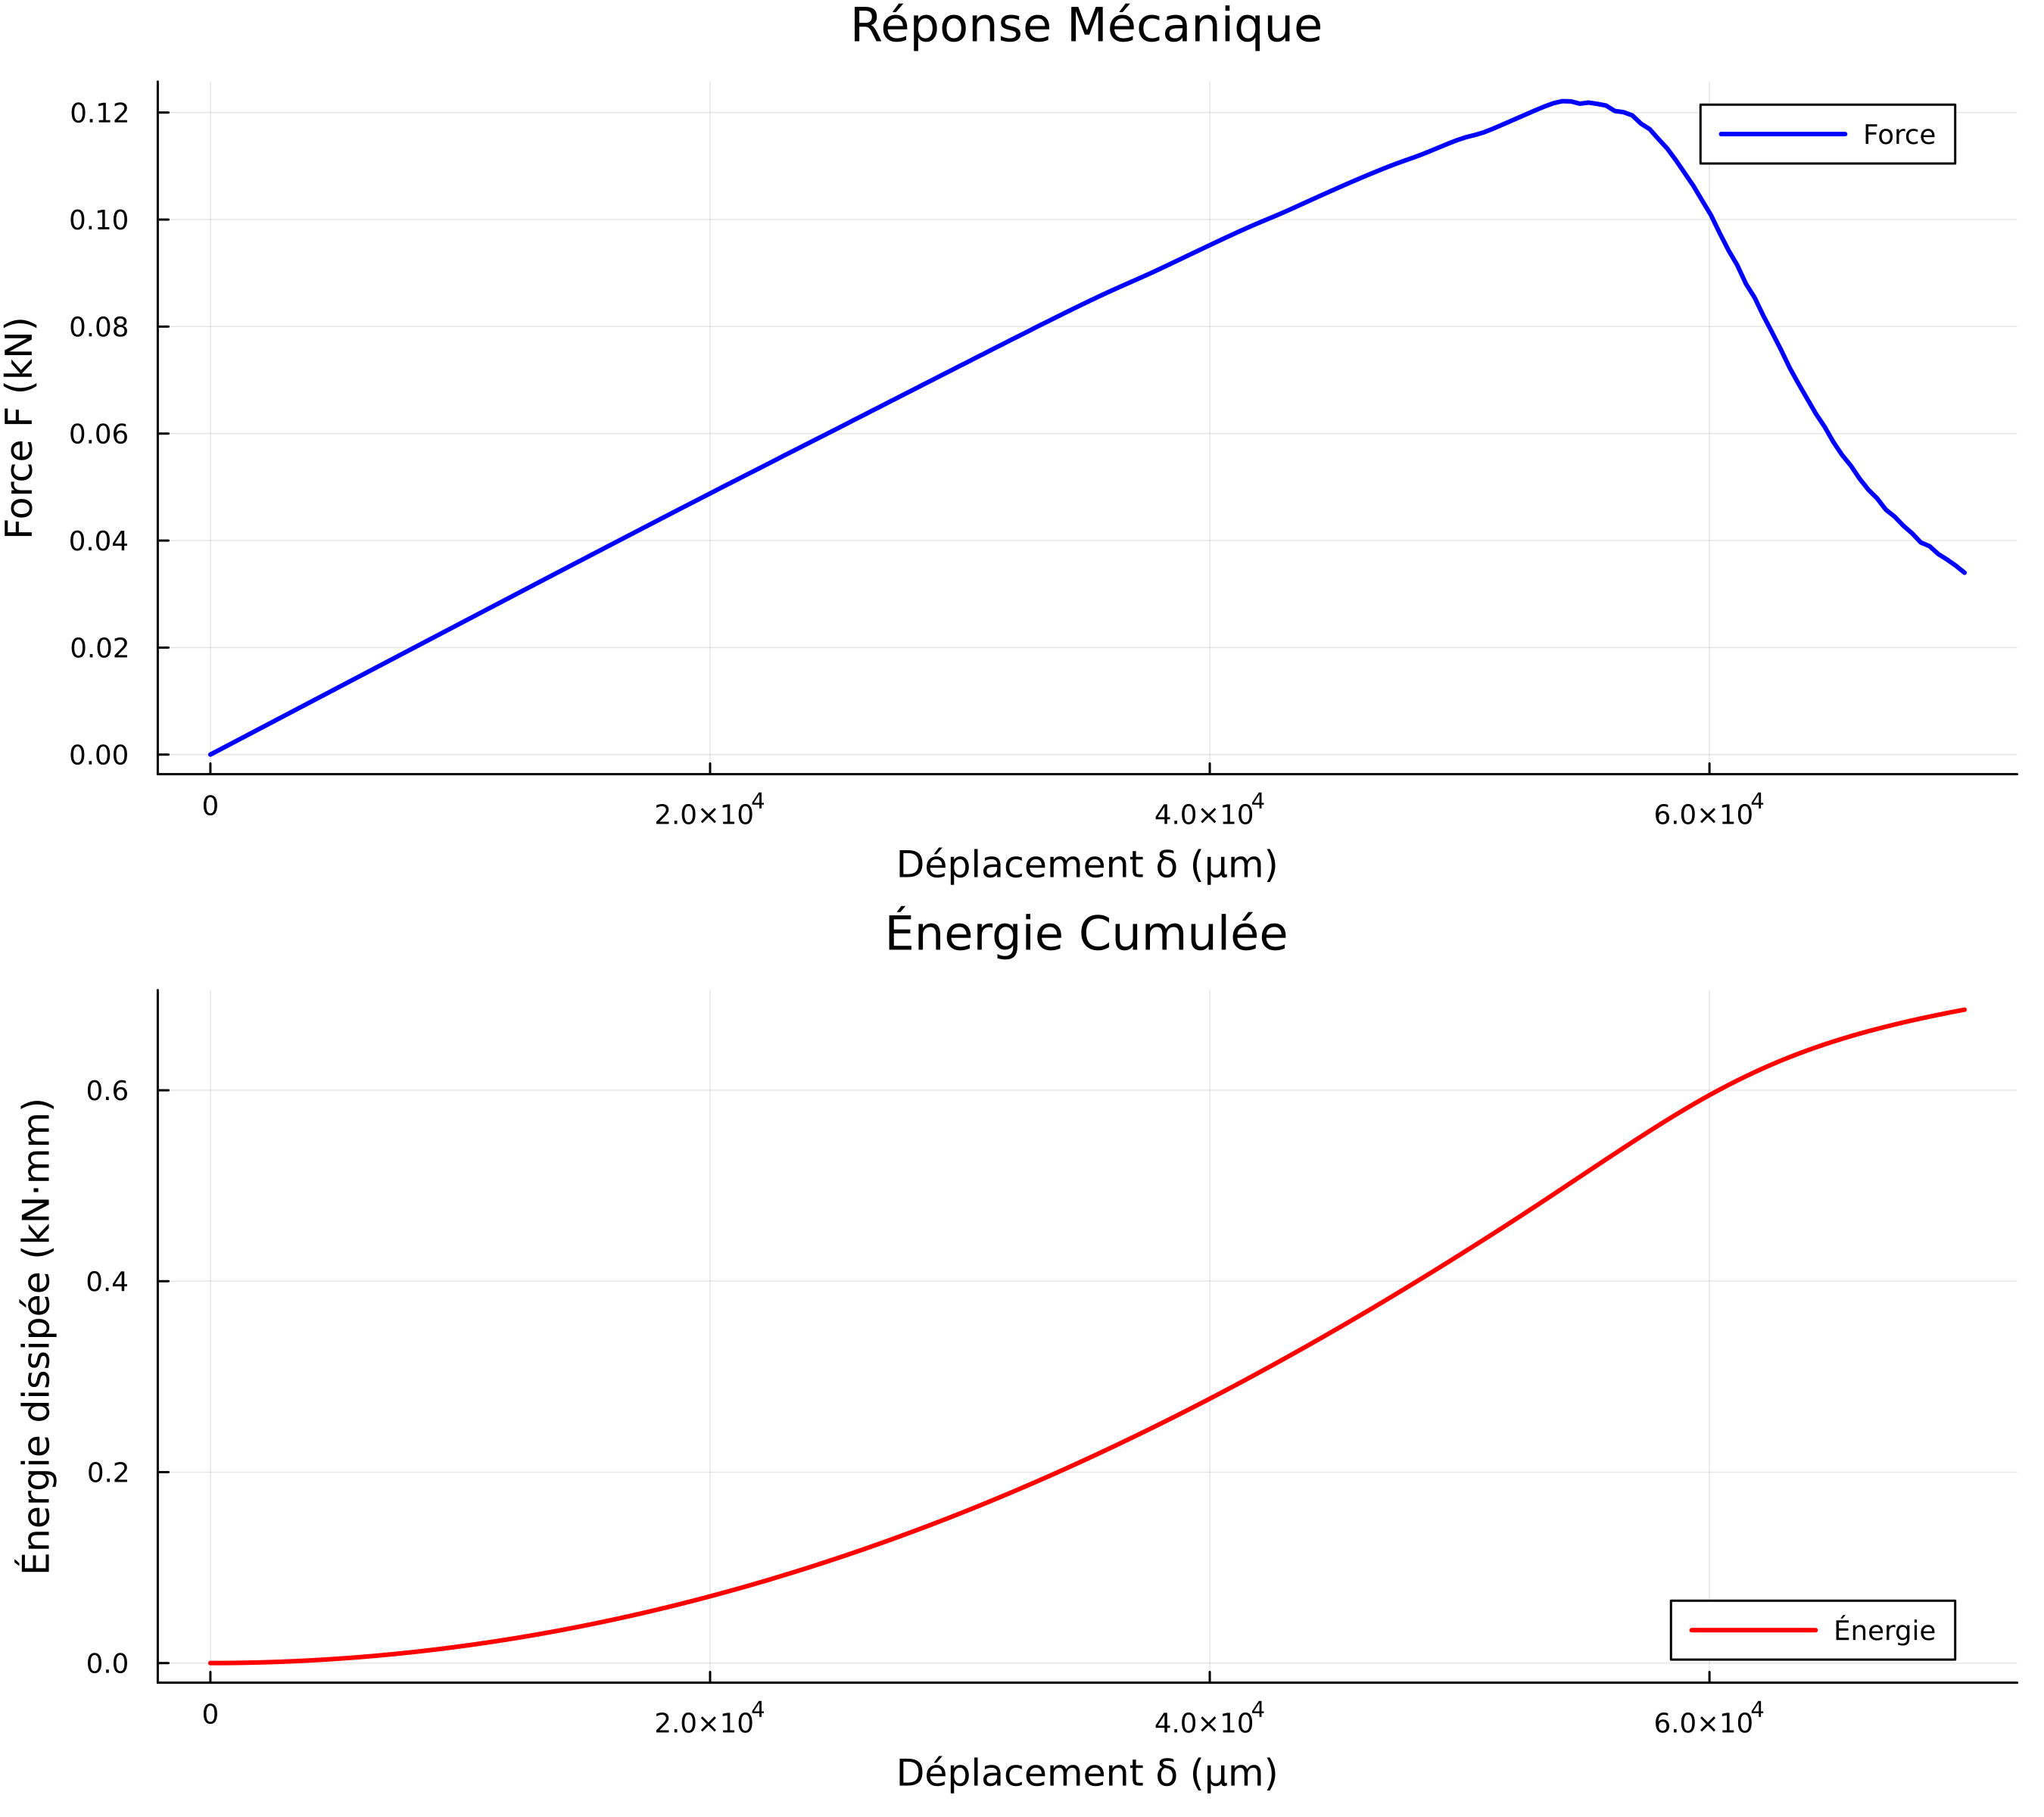

📊 Analyse énergétique sauvegardée: energy_analysis.png

3️⃣  Distribution du Champ de Phase...


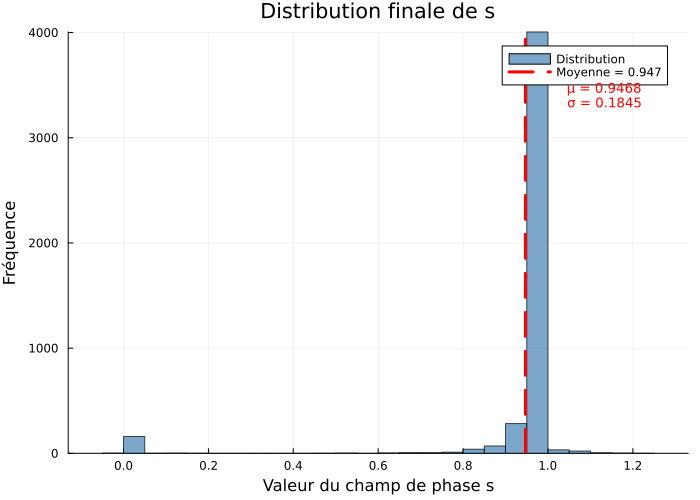

📊 Distribution sauvegardée: phase_field_distribution.png

⚠️  Pas d'historique sh_history - Evolution non tracée

5️⃣  Résumé Numérique...

📊 RÉSUMÉ DES RÉSULTATS

🔧 PARAMÈTRES DE SIMULATION:
   • Humidité globale: θ = 0.990
   • Module d'Young: E(θ) = 0.22 GPa
   • Coefficient de Poisson: ν(θ) = 0.250
   • Énergie de rupture: Gc(θ) = 4.21e-04 kN/mm
   • Longueur caractéristique: ls = 0.0100 mm

📈 RÉPONSE MÉCANIQUE:
   • Force maximale: Fmax = 0.1221 kN
   • Déplacement à Fmax: δ = 7.7300 mm (7730.00 µm)
   • Déplacement final: δ_final = 10.0300 mm (10030.00 µm)
   • Nombre de pas de charge: 231
   • Énergie totale dissipée: W = 0.684418 kN·mm

🔍 CHAMP DE PHASE (état final):
   • Minimum: s_min = -0.000001
   • Moyenne: s_moy = 0.946850
   • Médiane: s_med = 0.994220
   • Maximum: s_max = 1.201321
   • Écart-type: σ_s = 0.184496
   • Volume endommagé (s < 0.9): 6.61%
   • Volume intact (s > 0.99): 57.83%


6️⃣  Sauvegarde VTK...
💾 Fichier VTK: final_state_complete.vtu

✅ POST-TRAITEMEN

In [ ]:
# ============================================================================
# POST-TRAITEMENT CORRIGÉ - Compatible avec Plots.jl
# ============================================================================

# ⚠️ IMPORTANT: Installer et charger Plots.jl au lieu de PyPlot
# Dans Julia REPL: ] add Plots
# Puis redémarrer le kernel et ajouter cette cellule AVANT les autres:

using Plots
using Statistics
using Printf
gr()  # Backend GR (rapide et efficace)

# ----------------------------------------------------------------------------
# 1. COURBE FORCE-DÉPLACEMENT
# ----------------------------------------------------------------------------

function plot_results(Displacement, Load)
    """
    Trace la courbe force-déplacement avec Plots.jl
    """
    
    disp_um = Displacement .* 7000  # mm → µm
    
    # Créer le plot
    p = plot(disp_um, Load,
        xlabel = "Déplacement imposé δ (µm)",
        ylabel = "Force de réaction F (kN)",
        title = "Courbe Force-Déplacement (θ = $θ_global)",
        linewidth = 2.5,
        linecolor = :blue,
        label = "Simulation",
        legend = :topright,  # ✅ Syntaxe correcte pour Plots.jl
        grid = true,
        gridstyle = :dash,
        gridalpha = 0.3,
        size = (900, 600),
        dpi = 300,
        framestyle = :box,
        margin = 5Plots.mm
    )
    
    # Ajouter des marqueurs
    n_markers = min(15, length(disp_um))
    marker_idx = round.(Int, range(1, length(disp_um), length=n_markers))
    scatter!(p, disp_um[marker_idx], Load[marker_idx],
        markersize = 5,
        markercolor = :red,
        markerstrokewidth = 1,
        markerstrokecolor = :darkred,
        label = ""
    )
    
    # Annoter le point maximum
    max_force = maximum(Load)
    max_idx = argmax(Load)
    max_disp = disp_um[max_idx]
    
    annotate!(p, max_disp + 5, max_force - 0.0005,
        text(@sprintf("Fmax = %.4f kN\nδ = %.1f µm", max_force, max_disp),
             :left, 9, :red))
    
    # Ligne horizontale au maximum
    hline!(p, [max_force], 
        linestyle = :dash, 
        linecolor = :red, 
        alpha = 0.3, 
        label = ""
    )
    
    # Afficher et sauvegarder
    display(p)
    savefig(p, "force_displacement_theta_$(θ_global).png")
    println("\n📊 Figure sauvegardée: force_displacement_theta_$(θ_global).png")
    
    return p
end


# ----------------------------------------------------------------------------
# 2. ANALYSE ÉNERGÉTIQUE
# ----------------------------------------------------------------------------

function plot_energy_analysis(Displacement, Load)
    """
    Calcule et trace l'énergie dissipée
    """
    
    disp_um = Displacement .* 7000
    
    # Calcul de l'énergie (intégrale trapézoïdale)
    energy = zeros(length(Load))
    for i in 2:length(Load)
        energy[i] = energy[i-1] + 0.5 * (Load[i] + Load[i-1]) * (Displacement[i] - Displacement[i-1])
    end
    
    # Subplot 1: Force-Déplacement
    p1 = plot(disp_um, Load,
        xlabel = "Déplacement δ (µm)",
        ylabel = "Force F (kN)",
        title = "Réponse Mécanique",
        linewidth = 2,
        linecolor = :blue,
        label = "Force",
        legend = :topright,
        grid = true
    )
    
    # Subplot 2: Énergie dissipée
    p2 = plot(disp_um, energy,
        xlabel = "Déplacement δ (µm)",
        ylabel = "Énergie dissipée (kN·mm)",
        title = "Énergie Cumulée",
        linewidth = 2,
        linecolor = :red,
        label = "Énergie",
        legend = :bottomright,
        grid = true
    )
    
    # Combiner les deux plots
    p = plot(p1, p2, 
        layout = (2, 1), 
        size = (900, 800), 
        dpi = 300
    )
    
    display(p)
    savefig(p, "energy_analysis.png")
    println("📊 Analyse énergétique sauvegardée: energy_analysis.png")
    
    return p, energy
end


# ----------------------------------------------------------------------------
# 3. DISTRIBUTION DU CHAMP DE PHASE
# ----------------------------------------------------------------------------

function plot_damage_stats(sh, Displacement)
    """
    Histogramme et statistiques du champ de phase
    """
    
    sh_values = get_free_dof_values(sh)
    
    # Créer l'histogramme
    p1 = histogram(sh_values,
        bins = 50,
        xlabel = "Valeur du champ de phase s",
        ylabel = "Fréquence",
        title = "Distribution finale de s",
        color = :steelblue,
        alpha = 0.7,
        legend = :topright,
        size = (700, 500),
        grid = true,
        label = "Distribution"
    )
    
    # Calculer statistiques
    mean_val = mean(sh_values)
    std_val = std(sh_values)
    
    # Ajouter la ligne de moyenne
    vline!(p1, [mean_val], 
        linewidth = 3, 
        linecolor = :red, 
        linestyle = :dash,
        label = @sprintf("Moyenne = %.3f", mean_val)
    )
    
    # ✅ CORRECTION: Utiliser ylims() pour position automatique
    ylims_current = ylims(p1)
    y_annotation = ylims_current[2] * 0.85
    
    # Annotation avec statistiques
    annotate!(p1, mean_val + 0.1, y_annotation,
        text(@sprintf("μ = %.4f\nσ = %.4f", mean_val, std_val), 
             :left, 9, :red))
    
    display(p1)
    savefig(p1, "phase_field_distribution.png")
    println("📊 Distribution sauvegardée: phase_field_distribution.png")
    
    return p1
end


# ----------------------------------------------------------------------------
# 4. ÉVOLUTION DU CHAMP DE PHASE (si historique disponible)
# ----------------------------------------------------------------------------

function plot_damage_evolution(Displacement, sh_history)
    """
    Trace l'évolution des statistiques du champ de phase
    
    Note: Nécessite sh_history (liste des champs de phase sauvegardés)
    """
    
    if isempty(sh_history)
        println("⚠️  Historique vide. Utilisez la boucle modifiée pour sauvegarder sh_history.")
        return nothing
    end
    
    # Calculer les statistiques
    s_min = Float64[]
    s_max = Float64[]
    s_mean = Float64[]
    damage_pct = Float64[]
    
    for sh in sh_history
        sh_vals = get_free_dof_values(sh)
        push!(s_min, minimum(sh_vals))
        push!(s_max, maximum(sh_vals))
        push!(s_mean, mean(sh_vals))
        push!(damage_pct, 100 * sum(sh_vals .< 0.9) / length(sh_vals))
    end
    
    # Plot 1: Min/Moy/Max
    p1 = plot(disp_um, [s_min s_mean s_max],
        xlabel = "Déplacement δ (µm)",
        ylabel = "Champ de phase s",
        title = "Évolution de s",
        linewidth = 2,
        label = ["Min" "Moyen" "Max"],
        legend = :right,
        ylim = (-0.1, 1.1),
        grid = true
    )
    
    # Plot 2: Pourcentage endommagé
    p2 = plot(disp_um, damage_pct,
        xlabel = "Déplacement δ (µm)",
        ylabel = "Volume endommagé (%)",
        title = "Propagation de l'endommagement",
        linewidth = 2,
        linecolor = :red,
        label = "s < 0.9",
        legend = :topleft,
        grid = true
    )
    
    p = plot(p1, p2, layout = (2, 1), size = (900, 800), dpi = 300)
    
    display(p)
    savefig(p, "damage_evolution.png")
    println("📊 Évolution sauvegardée: damage_evolution.png")
    
    return p
end


# ----------------------------------------------------------------------------
# 5. RÉSUMÉ TEXTUEL
# ----------------------------------------------------------------------------

function print_summary(Displacement, Load, sh)
    """
    Affiche un résumé complet des résultats
    """
    
    println("\n" * "="^80)
    println("📊 RÉSUMÉ DES RÉSULTATS")
    println("="^80)
    
    # Paramètres
    println("\n🔧 PARAMÈTRES DE SIMULATION:")
    println(@sprintf("   • Humidité globale: θ = %.3f", θ_global))
    println(@sprintf("   • Module d'Young: E(θ) = %.2f GPa", E_moisture(θ_global)))
    println(@sprintf("   • Coefficient de Poisson: ν(θ) = %.3f", ν_dry + θ_global*(ν_sat - ν_dry)))
    println(@sprintf("   • Énergie de rupture: Gc(θ) = %.2e kN/mm", Gc_moisture(θ_global)))
    println(@sprintf("   • Longueur caractéristique: ls = %.4f mm", ls))
    
    # Réponse mécanique
    max_force = maximum(Load)
    max_idx = argmax(Load)
    
    println("\n📈 RÉPONSE MÉCANIQUE:")
    println(@sprintf("   • Force maximale: Fmax = %.4f kN", max_force))
    println(@sprintf("   • Déplacement à Fmax: δ = %.4f mm (%.2f µm)", 
                    Displacement[max_idx], Displacement[max_idx]*1000))
    println(@sprintf("   • Déplacement final: δ_final = %.4f mm (%.2f µm)", 
                    Displacement[end], Displacement[end]*1000))
    println(@sprintf("   • Nombre de pas de charge: %d", length(Load)))
    
    # Énergie
    energy_total = 0.0
    for i in 2:length(Load)
        energy_total += 0.5 * (Load[i] + Load[i-1]) * (Displacement[i] - Displacement[i-1])
    end
    println(@sprintf("   • Énergie totale dissipée: W = %.6f kN·mm", energy_total))
    
    # Champ de phase
    sh_values = get_free_dof_values(sh)
    println("\n🔍 CHAMP DE PHASE (état final):")
    println(@sprintf("   • Minimum: s_min = %.6f", minimum(sh_values)))
    println(@sprintf("   • Moyenne: s_moy = %.6f", mean(sh_values)))
    println(@sprintf("   • Médiane: s_med = %.6f", median(sh_values)))
    println(@sprintf("   • Maximum: s_max = %.6f", maximum(sh_values)))
    println(@sprintf("   • Écart-type: σ_s = %.6f", std(sh_values)))
    
    damaged_pct = 100 * sum(sh_values .< 0.9) / length(sh_values)
    intact_pct = 100 * sum(sh_values .> 0.99) / length(sh_values)
    println(@sprintf("   • Volume endommagé (s < 0.9): %.2f%%", damaged_pct))
    println(@sprintf("   • Volume intact (s > 0.99): %.2f%%", intact_pct))
    
    println("\n" * "="^80)
end


# ----------------------------------------------------------------------------
# 6. FONCTION PRINCIPALE DE POST-TRAITEMENT
# ----------------------------------------------------------------------------

function run_postprocessing(Displacement, Load, uh, sh, Ω; sh_history=nothing)
    """
    Exécute tous les post-traitements
    
    Arguments:
    - Displacement, Load: vecteurs de résultats
    - uh: champ de déplacement final
    - sh: champ de phase final
    - Ω: triangulation
    - sh_history: (optionnel) historique des champs de phase
    """
    
    println("\n" * "="^80)
    println("🎨 GÉNÉRATION DES POST-TRAITEMENTS")
    println("="^80)
    
    # 1. Courbe force-déplacement
    println("\n1️⃣  Courbe Force-Déplacement...")
    plot_results(Displacement, Load)
    
    # 2. Analyse énergétique
    println("\n2️⃣  Analyse Énergétique...")
    plot_energy_analysis(Displacement, Load)
    
    # 3. Distribution du champ de phase
    println("\n3️⃣  Distribution du Champ de Phase...")
    plot_damage_stats(sh, Displacement)
    
    # 4. Évolution (si historique disponible)
    if sh_history !== nothing && !isempty(sh_history)
        println("\n4️⃣  Évolution de l'Endommagement...")
        plot_damage_evolution(Displacement, sh_history)
    else
        println("\n⚠️  Pas d'historique sh_history - Evolution non tracée")
    end
    
    # 5. Résumé textuel
    println("\n5️⃣  Résumé Numérique...")
    print_summary(Displacement, Load, sh)
    
    # 6. Sauvegarder état final en VTK
    println("\n6️⃣  Sauvegarde VTK...")
    writevtk(Ω, "final_state_complete", cellfields = [
        "displacement" => uh,
        "phase_field" => sh,
        "displacement_magnitude" => uh,
        "epsilon" => ε(uh),
        "sigma" => σ_elas ∘ (ε(uh))
    ])
    println("💾 Fichier VTK: final_state_complete.vtu")
    
    println("\n" * "="^80)
    println("✅ POST-TRAITEMENT TERMINÉ!")
    println("="^80)
    println("\n📁 Fichiers générés:")
    println("   • force_displacement_theta_$(θ_global).png")
    println("   • energy_analysis.png")
    println("   • phase_field_distribution.png")
    if sh_history !== nothing && !isempty(sh_history)
        println("   • damage_evolution.png")
    end
    println("   • final_state_complete.vtu")
    println()
end


# ============================================================================
# UTILISATION: Ajouter cette cellule APRÈS la cellule 28
# ============================================================================

# Exécuter tous les post-traitements
run_postprocessing(Displacement, Load, uh, sh, Ω)

# Ou exécuter individuellement:
# plot_results(Displacement, Load)
# plot_energy_analysis(Displacement, Load)
# plot_damage_stats(sh, Displacement)
# print_summary(Displacement, Load, sh)

In [29]:
# ============================================================================
# SAUVEGARDE DES RÉSULTATS ET PRÉPARATION POUR COMPARAISON
# ============================================================================

# Calcul des paramètres mécaniques effectifs
E_eff = E_moisture(θ_global)
ν_eff = ν_dry + θ_global*(ν_sat - ν_dry)
Gc_eff = Gc_moisture(θ_global)

# Identification des points clés
max_force = maximum(Load)
max_force_idx = argmax(Load)
disp_at_max = Displacement[max_force_idx]

# Statistiques sur le champ de phase final
sh_values = get_free_dof_values(sh)
damaged_volume = 100 * sum(sh_values .< 0.9) / length(sh_values)

# Sauvegarde des résultats principaux au format JLD2
using JLD2

results_dict = Dict(
    "parameters" => Dict(
        "theta" => θ_global,
        "E" => E_eff,
        "nu" => ν_eff,
        "Gc" => Gc_eff,
        "ls" => ls
    ),
    "force_displacement" => Dict(
        "displacement" => Displacement,
        "force" => Load
    ),
    "key_results" => Dict(
        "max_force" => max_force,
        "disp_at_max_force" => disp_at_max,
        "damaged_volume_percent" => damaged_volume
    )
)

# Nom du fichier basé sur les paramètres
filename = @sprintf("results_theta_%.2f.jld2", θ_global)
@save filename results_dict

println("\n💾 Résultats sauvegardés dans: $filename")
println("\n📊 Résumé des résultats principaux:")
println("   • Force maximale: $(round(max_force, digits=4)) kN")
println("   • Déplacement à Fmax: $(round(disp_at_max*1000, digits=2)) μm")
println("   • Volume endommagé: $(round(damaged_volume, digits=2))%")
println("   • Module d'Young effectif: $(round(E_eff, digits=3)) GPa")
println("   • Coefficient de Poisson effectif: $(round(ν_eff, digits=3))")
println("\n🔍 Les données sont prêtes pour la comparaison avec les résultats expérimentaux.")

LoadError: ArgumentError: Package JLD2 not found in current path.
- Run `import Pkg; Pkg.add("JLD2")` to install the JLD2 package.

In [27]:
using CSV
using DataFrames

# Création d'un DataFrame avec les résultats principaux
results_df = DataFrame(
    Displacement_mm = Displacement .* 1000,  # Conversion en mm
    Load_kN = Load
)

# Ajout des paramètres de simulation comme métadonnées
metadata_df = DataFrame(
    Parameter = [
        "Global_Humidity",
        "Young_Modulus_GPa",
        "Poisson_Ratio",
        "Fracture_Energy_kN_per_mm",
        "Characteristic_Length_mm",
        "Max_Load_kN",
        "Final_Displacement_mm"
    ],
    Value = [
        θ_global,
        E_moisture(θ_global),
        ν_dry + θ_global*(ν_sat - ν_dry),
        Gc_moisture(θ_global),
        ls,
        maximum(Load),
        Displacement[end] * 1000
    ]
)

# Sauvegarde des résultats
filename_results = "simulation_results_theta_$(θ_global).csv"
filename_metadata = "simulation_metadata_theta_$(θ_global).csv"

CSV.write(filename_results, results_df)
CSV.write(filename_metadata, metadata_df)

println("\n💾 Fichiers sauvegardés:")
println("   • $filename_results")
println("   • $filename_metadata")

LoadError: ArgumentError: Package CSV not found in current path.
- Run `import Pkg; Pkg.add("CSV")` to install the CSV package.

In [28]:
using XLSX
using Plots
using Statistics
using Printf

# Lecture des données expérimentales
xf = XLSX.readxlsx("DONNEESEXPERIMENTALES.xlsx")
sheet = xf[1]  # Première feuille
exp_data = sheet[:]  # Toutes les données

# Supposons que les colonnes sont: Déplacement (mm) et Force (kN)
exp_disp = convert(Vector{Float64}, exp_data[:,1])  # Première colonne
exp_force = convert(Vector{Float64}, exp_data[:,2])  # Deuxième colonne

# Conversion des déplacements de simulation en mm (initialement en mm)
sim_disp = Displacement .* 1000  # si nécessaire de convertir

# Création du graphique
p = plot(
    # Données de simulation
    sim_disp, Load,
    label="Simulation (θ = $θ_global)",
    linewidth=2,
    linestyle=:solid,
    linecolor=:blue,
    
    # Options du graphique
    xlabel="Déplacement (mm)",
    ylabel="Force (kN)",
    title="Comparaison Simulation vs Expérimental",
    grid=true,
    gridstyle=:dash,
    gridalpha=0.3,
    size=(900, 600),
    dpi=300,
    legend=:topright
)

# Ajout des données expérimentales
plot!(p, exp_disp, exp_force,
    label="Expérimental",
    linewidth=2,
    linestyle=:dash,
    linecolor=:red,
    marker=:circle,
    markersize=3,
    markerstrokewidth=1
)

# Calcul et affichage des forces maximales
max_sim = maximum(Load)
max_exp = maximum(exp_force)
diff_pct = abs(max_sim - max_exp) / max_exp * 100

annotate!(p, maximum(sim_disp)*0.6, maximum([max_sim, max_exp]),
    text(@sprintf("Fmax sim = %.3f kN\nFmax exp = %.3f kN\nDiff = %.1f%%",
        max_sim, max_exp, diff_pct),
        :left, 8, :black))

# Affichage et sauvegarde
display(p)
savefig(p, "simulation_vs_experimental.png")

# Affichage des statistiques
println("\n" * "="^50)
println("📊 COMPARAISON SIMULATION VS EXPÉRIMENTAL")
println("="^50)
println(@sprintf("Force max simulation: %.3f kN", max_sim))
println(@sprintf("Force max expérimentale: %.3f kN", max_exp))
println(@sprintf("Différence relative: %.1f%%", diff_pct))
println("="^50)

LoadError: AssertionError: File DONNEESEXPERIMENTALES.xlsx not found.